In [166]:
# Import the following basic libraries
import pandas as pd
import numpy as np
from collections import defaultdict
from collections import Counter
import csv
import re 
import string

# To change date to datetime
from datetime import datetime
import time


# Visualization libraries
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

# Avoid warnings
import warnings
warnings.filterwarnings("ignore")

# Enable logging for gensim - optional but important
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


from IPython.display import clear_output
clear_output()


# NLTK libraries
import nltk
from nltk.corpus import stopwords,wordnet
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

#Modelling
import xgboost as xg
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split,cross_val_score,KFold,RandomizedSearchCV
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity,pairwise_distances
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

#OverSampling
from imblearn import over_sampling

In [2]:
# To show all the columns
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)

## <font color='blue'>Load the Dataset</font>

In [3]:
df = pd.read_csv('sample30.csv')

In [4]:
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


## <font color='blue'>Data Cleaning</font>

In [5]:
# Print the shape of the dataset.
print("Shape :", df.shape)

Shape : (30000, 15)


In [6]:
# Print the columns of the dataset.
print(f"Columns :{df.columns.values}")

Columns :['id' 'brand' 'categories' 'manufacturer' 'name' 'reviews_date'
 'reviews_didPurchase' 'reviews_doRecommend' 'reviews_rating'
 'reviews_text' 'reviews_title' 'reviews_userCity' 'reviews_userProvince'
 'reviews_username' 'user_sentiment']


In [7]:
# Print the information about the dataset columns.
print(f"Info :{df.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [8]:
# Finding the count of missing values in each columns.
print(f"Missing Value Count :{df.isnull().sum()}")

Missing Value Count :id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64


In [9]:
#Finding the percentage of missing values in each columns.
print(f"Percentage of Missing Values: {df.isna().mean().round(4)*100}")

Percentage of Missing Values: id                       0.00
brand                    0.00
categories               0.00
manufacturer             0.47
name                     0.00
reviews_date             0.15
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_rating           0.00
reviews_text             0.00
reviews_title            0.63
reviews_userCity        93.57
reviews_userProvince    99.43
reviews_username         0.21
user_sentiment           0.00
dtype: float64


In [10]:
# Drop the columns with more than 50% of missing values.
missing_val_threshold = len(df) * 0.5
df.dropna(thresh=missing_val_threshold,axis=1,inplace=True)

In [11]:
df['reviews_doRecommend'].value_counts()

reviews_doRecommend
True     25880
False     1550
Name: count, dtype: int64

In [12]:
df['reviews_didPurchase'].value_counts()

reviews_didPurchase
False    14498
True      1434
Name: count, dtype: int64

In [13]:
# Drop the 'reviews_doRecommend'& 'reviews_didPurchase' column also as this is of no use for our analysis.

In [14]:
df = df.drop(columns=['reviews_doRecommend','reviews_didPurchase'])

In [15]:
df.sample(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
11620,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Clea...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,2012-01-31T00:00:00.000Z,5,I like this product because it is convenient and easy to use. The lemon scent smells good and makes my kitchen smell fresh. Even after getting raw meat on my counters I can trust that they are clean after using these disinfecting wipes. They are great!,This product is very handy.,couponc,Positive
17670,AVpfBrUZilAPnD_xTUly,Coty,"Personal Care,Makeup,Concealer & Foundation,Foundation,Facial Powder,Beauty,Face",Coty brands,"Coty Airspun Face Powder, Translucent Extra Coverage",2014-09-14T00:00:00.000Z,5,"It has a medicinal smell to it, which was a disappointment, because I happened to like the way it used to smell. Not sure why they changed that. Same great coverage where a little goes a LONG way. If you use too much, you look like a mannequin. Use sparingly.",Doesn't smell the same,greatsouthwestshopper,Negative


In [16]:
#Finding the percentage of missing values in remaining columns.
print(f"Percentage of Missing Values: {df.isna().mean().round(4)*100}")

Percentage of Missing Values: id                  0.00
brand               0.00
categories          0.00
manufacturer        0.47
name                0.00
reviews_date        0.15
reviews_rating      0.00
reviews_text        0.00
reviews_title       0.63
reviews_username    0.21
user_sentiment      0.00
dtype: float64


In [17]:
# Drop the NULL value rows of reviews_text, reviews_title, reviews_username, user_sentiment, reviews_date, manufacture.
df = df[df['reviews_text'].notna()]
df = df[df['reviews_title'].notna()]
df = df[df['reviews_username'].notna()]
df = df[df['user_sentiment'].notna()]
df = df[df['reviews_date'].notna()]
df = df[df['manufacturer'].notna()]

In [167]:
#Finding the percentage of missing values in remaining columns.
print(f"Percentage of Missing Values: {df.isna().mean().round(4)*100}")

Percentage of Missing Values: id                0.0
brand             0.0
categories        0.0
manufacturer      0.0
prod_name         0.0
reviews_date      0.0
reviews_rating    0.0
reviews_text      0.0
reviews_title     0.0
userID            0.0
user_sentiment    0.0
Reviews           0.0
Reviws            0.0
dtype: float64


In [19]:
# Renaming the columns
df.rename(columns={'reviews_username' : 'userID','name':'prod_name'}, inplace=True)

In [20]:
df.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'prod_name',
       'reviews_date', 'reviews_rating', 'reviews_text', 'reviews_title',
       'userID', 'user_sentiment'],
      dtype='object')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29566 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              29566 non-null  object
 1   brand           29566 non-null  object
 2   categories      29566 non-null  object
 3   manufacturer    29566 non-null  object
 4   prod_name       29566 non-null  object
 5   reviews_date    29566 non-null  object
 6   reviews_rating  29566 non-null  int64 
 7   reviews_text    29566 non-null  object
 8   reviews_title   29566 non-null  object
 9   userID          29566 non-null  object
 10  user_sentiment  29566 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.7+ MB


**Converting the Target Variable (user_sentiment) into Binary Numerical Value for Modelling Purposes**

In [22]:
# Convert the user sentiment column into binary values: Positive to 1 and Negative to 0.

def get_sentiment_binary(x):
    if (x=='Positive'):
        return 1
    else:
        return 0

In [23]:
#Convert user_sentiment string into binary.
df['user_sentiment'] = df['user_sentiment'].apply(get_sentiment_binary)

In [24]:
df.head()

,id,brand,categories,manufacturer,prod_name,reviews_date,reviews_rating,reviews_text,reviews_title,userID,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor.,Good,dorothy w,1
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,rebecca,0
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0


## <font color='blue'>Text Processing</font>

**Combine Review Text and Title into one**

In [25]:
df['reviews_title']

0                       Just Awesome
1                               Good
2                               Good
3                       Disappointed
4                         Irritation
                    ...             
29995                     Softness!!
29996                      I love it
29997    Hair is so smooth after use
29998      Perfect for my oily hair!
29999       Conditioned into healthy
Name: reviews_title, Length: 29566, dtype: object

In [26]:
df['reviews_text'].sample(2)

15720    I love it. My mother always used it when we stepped on a nail or were sick. It worked well and so I used it on my kids. I now put a little in my bathwater to kill germs there. Thanks so much for selling it. All the stores in my town are no longer selling it.
25437                                                                                                                       Good not great. Took too long for the big reveal. Cheesy, but full of great visuals and amazing special effects. Looking forward to the sequel.
Name: reviews_text, dtype: object

In [27]:
df['Reviews'] = df['reviews_title']+ " "+df['reviews_text']

In [28]:
df['Reviews'].head()

0                                                                                         Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1                                                                                                                                                                                                                                            Good Good flavor. This review was collected as part of a promotion.
2                                                                                                                                                                                                                                                                                              Good Good flavor.
3    Disappointed I read through the reviews on here before looking in to buying one 

**Lowercasing**

In [29]:
df['Reviews'] = df['Reviews'].apply(lambda x :x.lower())

In [30]:
df['Reviews']

0                                                                                             just awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. so hype! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1                                                                                                                                                                                                                                                good good flavor. this review was collected as part of a promotion.
2                                                                                                                                                                                                                                                                                                  good good flavor.
3        disappointed i read through the reviews on here before looking i

**Remove Punctuation**

In [31]:
df['Reviws']=df['Reviews'].str.replace('[^\w\s]','')

In [32]:
df['Reviews'].sample(3)

11628    loving these wipes i love how these wipes get the job done. you can try to find cheaper brands, but you'll find you need four times the wipes to do the same job so they aren't saving you any money. knowing they disinfect surfaces lets me feel at peace after a mess. this review was collected as p...
9492                                                                                                                                                                         i use them all over! i love the clorox wipes, i use them all over my home and what i like about them is they don't leave a film behind.
22139                     need bigger bottle i love this lotion. it is not greasy. i love everything about it except that i need a bigger bottle to keep at my nightstand. i have to keep pulling the 3oz one from my purse every time i have to use it. please consider in selling it in bigger bottle pump. thanks
Name: Reviews, dtype: object

**Remove Stopwords**

In [33]:
df['Reviews'] = df['Reviews'].apply(lambda x:' '.join([word for word in x.split() if word not in stopwords.words('english') ]))

In [34]:
df['Reviews'].sample(3)

22410                                 bring back original formula, please! new formula horrible, smell same. please consider sales lost teenagers alone.
27594    great movie kids grown-ups alike saw movie kids theater, good decided get add library home well. really enjoyed movie, especially 6-yr-old son.
1867                                                                                                           ok mature adults. good teenage movie ages
Name: Reviews, dtype: object

 **Lemmatization**

In [35]:
wordnet_lemmatizer = WordNetLemmatizer() 

In [36]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    
    try:
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None
    except Exception as e:
        print(e)

In [37]:
 from nltk.corpus import wordnet 
wordnet.ADJ

'a'

In [38]:
lem = []
for i in df['Reviews']:
    nltk_tag = nltk.pos_tag(word_tokenize(i))
    for j in nltk_tag:
        try:
            w  =(j[0], nltk_tag_to_wordnet_tag(j[1]))
            print(w,w)
            lem.append(wordnet_lemmatizer.lemmatize(w[0],w[1]))
        except:
            pass
    print(lem)    

    break

('awesome', 'a') ('awesome', 'a')
('love', 'n') ('love', 'n')
('album', 'n') ('album', 'n')
('.', None) ('.', None)
('good', 'a') ('good', 'a')
('.', None) ('.', None)
('hip', 'n') ('hip', 'n')
('hop', 'a') ('hop', 'a')
('side', 'n') ('side', 'n')
('current', 'a') ('current', 'a')
('pop', 'n') ('pop', 'n')
('sound', 'n') ('sound', 'n')
('..', 'n') ('..', 'n')
('hype', 'n') ('hype', 'n')
('!', None) ('!', None)
('listen', 'a') ('listen', 'a')
('everyday', 'a') ('everyday', 'a')
('gym', 'n') ('gym', 'n')
('!', None) ('!', None)
('give', 'v') ('give', 'v')
('5star', None) ('5star', None)
('rating', 'n') ('rating', 'n')
('way', 'n') ('way', 'n')
('.', None) ('.', None)
('metaphors', 'n') ('metaphors', 'n')
('crazy', 'v') ('crazy', 'v')
('.', None) ('.', None)
['awesome', 'love', 'album', 'good', 'hip', 'hop', 'side', 'current', 'pop', 'sound', '..', 'hype', 'listen', 'everyday', 'gym', 'give', 'rating', 'way', 'metaphor', 'crazy']


In [39]:
def lemmatize_sentence(sentence):
    nltk_tag = nltk.pos_tag(word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tag = map(lambda x:(x[0],nltk_tag_to_wordnet_tag(x[1])),nltk_tag)
    lemmatized_sentence = []
    for word,tag in wordnet_tag:
    
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(wordnet_lemmatizer.lemmatize(word,tag))
    return " ".join(lemmatized_sentence)        

In [40]:
df['Reviews'] = df['Reviews'].apply(lambda x : lemmatize_sentence(x))

In [41]:
df['Reviews'].head(10)

0                                                                                                                                                                            awesome love album . good . hip hop side current pop sound .. hype ! listen everyday gym ! give 5star rating way . metaphor crazy .
1                                                                                                                                                                                                                                                             good good flavor . review collect part promotion .
2                                                                                                                                                                                                                                                                                             good good flavor .
3    disappoint read review look buy one couple lubricant , ultimately disappointed e

**Noise Removal**

In [42]:
def scrub_words(text):
    #remove html markup
    text = re.sub("(<.?>)"," ",text)
    #remove non-ascii and digits
    text = re.sub('(\\W|\\d)'," ",text)
    #rremove whitespaces
    text = text.strip()
    
    return text

In [43]:
df['Reviews']=df['Reviews'].apply(lambda x: scrub_words(x))

In [44]:
# Print the first review from row1
df['Reviews'].head(10)

0                                                                                                                                                                              awesome love album   good   hip hop side current pop sound    hype   listen everyday gym   give  star rating way   metaphor crazy
1                                                                                                                                                                                                                                                               good good flavor   review collect part promotion
2                                                                                                                                                                                                                                                                                               good good flavor
3    disappoint read review look buy one couple lubricant   ultimately disappointed e

## <font color='blue'>Defining Features & Target Variables, Train Test Split, Build the TF-IDF Vectorizer</font>

**Defining features and target variables**

In [45]:
x=df['Reviews'] 
y=df['user_sentiment']

In [46]:
#Distribution of the target variable data.
print(pd.Series(y).value_counts())

user_sentiment
1    26262
0     3304
Name: count, dtype: int64


In [47]:
#Distribution of the target variable data in terms of proportions.

print(f"Percentage of 1s: {(pd.Series(y).value_counts()[1]/pd.Series(y).value_counts().sum()).round(4)*100} % ")
print(f"Percentage of 0s: {(pd.Series(y).value_counts()[0]/pd.Series(y).value_counts().sum()).round(4)*100} % ")

Percentage of 1s: 88.83 % 
Percentage of 0s: 11.17 % 


<font color='red'>As you can see there are 89% positives and only 11% negative values in the dataset hence, it is an imbalanced dataset. You need to build the model using the original dataset and then you need do use different sampling techniques also to this dataset to make the ML model efficient.</font>

**Train Test Split**

In [48]:
# Split the dataset into test and train
seed = 50 

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

In [49]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((20696,), (8870,), (20696,), (8870,))

**TF-IDF Vectorizer**

* strip_accents :  Remove accents and perform other character normalization during the preprocessing step. ‘ascii’ is a fast method that only works on characters that have a direct ASCII mapping. ‘unicode’ is a slightly slower method that works on any characters. None (default) means no character normalization is performed.

* analyzer :  Whether the feature should be made of word or character n-grams.Option ‘char_wb’ creates character n-grams only from text inside word boundaries; n-grams at the edges of words are padded with space.

* toekn_pattern : Regular expression denoting what constitutes a “token”, only used if analyzer == 'word'

* ngram_pattern: The lower and upper boundary of the range of n-values for different n-grams to be extracted

* sublinear_tf : Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf). Default Value false

In [50]:
word_vectorizer= TfidfVectorizer( strip_accents="unicode",analyzer='word',token_pattern=r'\w{1,}',ngram_range=(1,3),
                                 stop_words='english',sublinear_tf=True)

word_vectorizer.fit(X_train)

TfidfVectorizer(ngram_range=(1, 3), stop_words='english',
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w{1,}')

In [51]:
#Transform on train
train_word_features = word_vectorizer.transform(X_train)

In [52]:
train_word_features

<20696x374010 sparse matrix of type '<class 'numpy.float64'>'
	with 933329 stored elements in Compressed Sparse Row format>

In [53]:
## transforming the train and test datasets
X_train_transformed = word_vectorizer.transform(X_train.tolist())
X_test_transformed = word_vectorizer.transform(X_test.tolist())
# Print the shape of each dataset.
print('X_train_transformed', X_train_transformed.shape)
print('y_train', y_train.shape)
print('X_test_transformed', X_test_transformed.shape)
print('y_test', y_test.shape)

X_train_transformed (20696, 374010)
y_train (20696,)
X_test_transformed (8870, 374010)
y_test (8870,)


## <font color='blue'>Model Building</font>

### `Logistic Regression`

<font color='brown'> **Logistic Regression Model- Without any sampling techniques**</font>

In [202]:
# Build the Logistic Regression model.

time1 =  time.time()

log_reg = LogisticRegression()
log_reg.fit(X_train_transformed,y_train)

time_taken = time.time() - time1

print(f"Time Taken : {time_taken} seconds ")

Time Taken : 6.341902017593384 seconds 


<font color='brown'>**Model Performance Metrics**</font>

In [55]:
#Prediction Train Data
y_pred_train = log_reg.predict(X_train_transformed)

#Model Performance on Train Dataset

print(f"Logistic Regression Accuracy : {accuracy_score(y_pred_train,y_train)}")
print(f"Classification Report : {classification_report(y_pred_train,y_train)}")

Logistic Regression Accuracy : 0.8997873985311171
Classification Report :               precision    recall  f1-score   support

           0       0.10      1.00      0.17       218
           1       1.00      0.90      0.95     20478

    accuracy                           0.90     20696
   macro avg       0.55      0.95      0.56     20696
weighted avg       0.99      0.90      0.94     20696



In [56]:
# Prediction Test Data
y_pred_test = log_reg.predict(X_test_transformed)

#Model Performance on Test Dataset
print("Logistic Regression accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))

Logistic Regression accuracy 0.8913190529875986
              precision    recall  f1-score   support

           0       0.06      0.82      0.11        74
           1       1.00      0.89      0.94      8796

    accuracy                           0.89      8870
   macro avg       0.53      0.86      0.53      8870
weighted avg       0.99      0.89      0.94      8870



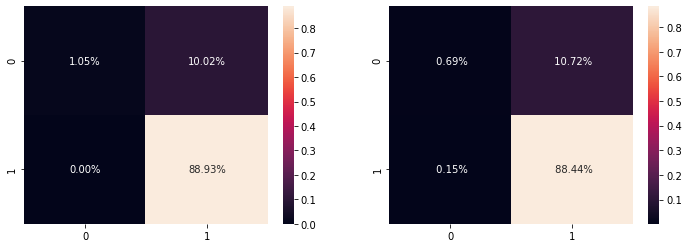

In [58]:
# Create the confusion matrix for Logistic regression.

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)

#Confusion Matrix for train set
cm_train = confusion_matrix(y_train,y_pred_train)
sns.heatmap(cm_train/np.sum(cm_train),annot=True,fmt=".2%")

plt.subplot(1,2,2)
# confusion matrix for the test data
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test/np.sum(cm_test), annot=True , fmt = ' .2%')


plt.show()

In [59]:
#For train set: TN: True Negative, FP: False Positive, FN: False Negative, TP: True Positive
TN_tr = cm_train[0, 0] 
FP_tr = cm_train[0, 1]
FN_tr = cm_train[1, 0]
TP_tr = cm_train[1, 1]

#for test set
TN = cm_test[0, 0]
FP = cm_test[0, 1]
FN = cm_test[1, 0]
TP = cm_test[1, 1]


* Sensitivity (True Positive Rate) is a measure of the proportion of actual positive cases that got predicted as positive.

* Specificity (True Negative Rate) is defined as the proportion of actual negatives, which got predicted as the negative (or true negative).

* True Positive Rate = True Positives / (True Positives + False Negatives)

* False Positive Rate = False Positives / (False Positives + True Negatives)

`The metrics that have been chosen are sensitivity and specificity. As you need to have more sensitivity as well as specificity.`

In [61]:
#Calculating the Sensitivity for train and test set
sensitivity_tr = TP_tr / float(FN_tr + TP_tr)
print("sensitivity for train set: ",sensitivity_tr)
sensitivity = TP / float(FN + TP)
print("sensitivity for test set: ",sensitivity)

sensitivity for train set:  1.0
sensitivity for test set:  0.998345635021634


In [62]:
#specificity for test and train set. 
specificity_tr = TN_tr / float(TN_tr + FP_tr)
print("specificity for train set: ",specificity_tr)
specificity = TN / float(TN + FP)
print("specificity for test set: ",specificity)

specificity for train set:  0.09511343804537521
specificity for test set:  0.06027667984189723


<font color='red'>Since the distribution of the dataset is imbalanced with more positives, many reviews which were negative were incorrectly classified as positives and hence, low specificity. From a business point of view, this is not a very good model as you will miss out on the negatives.</font>

<font color='brown'>**Logistic Regression Model : With Sampling Techniques**</font>

We can use different Sampling Techniques like -

1. Oversampling
2. Smote

In [54]:
# Split test and train
seed = 50 

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

In [55]:
y_train.value_counts(),y_test.value_counts()

(user_sentiment
 1    18404
 0     2292
 Name: count, dtype: int64,
 user_sentiment
 1    7858
 0    1012
 Name: count, dtype: int64)

In [56]:
ros = over_sampling.RandomOverSampler(random_state=0)

In [57]:
#Oversampling the dataset
X_train_os,y_train_os = ros.fit_resample(pd.DataFrame(X_train),pd.Series(y_train))

In [58]:
y_train_os.value_counts()

user_sentiment
1    18404
0    18404
Name: count, dtype: int64

In [75]:
X_train_os = pd.DataFrame(X_train_os).iloc[:,0].tolist()

In [78]:
len(X_train_os)

36808

In [79]:
# transforming the train and test datasets

# transforming the train and test datasets

X_train_transformed = word_vectorizer.transform(X_train)
X_test_transformed = word_vectorizer.transform(X_test.tolist())

In [81]:
# Building the Logistic Regression model
time1 = time.time()

logit = LogisticRegression()
logit.fit(X_train_transformed,y_train_os)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 5.29 seconds


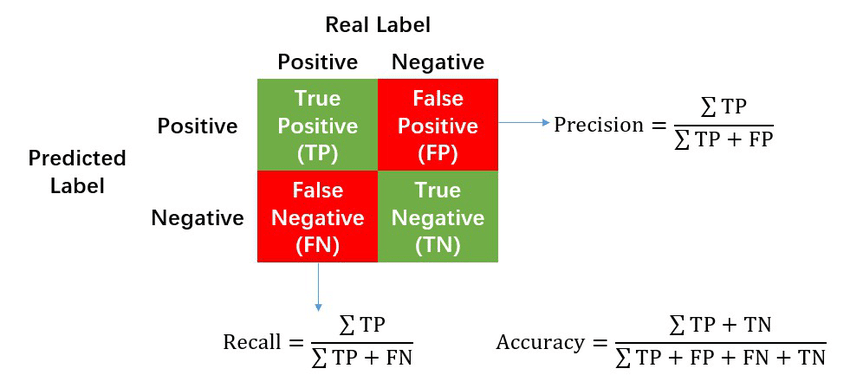

In [83]:
# Prediction Train Data
y_pred_train= logit.predict(X_train_transformed)

#Model Performance on Train Dataset
print("Logistic Regression accuracy", accuracy_score(y_pred_train, y_train_os))
print(classification_report(y_pred_train, y_train_os))

Logistic Regression accuracy 0.9892143012388611
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     18731
           1       0.98      1.00      0.99     18077

    accuracy                           0.99     36808
   macro avg       0.99      0.99      0.99     36808
weighted avg       0.99      0.99      0.99     36808



In [84]:
# Prediction Test Data
y_pred_test = logit.predict(X_test_transformed)

print("Logistic Regression accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))
print(confusion_matrix(y_pred_test, y_test))

Logistic Regression accuracy 0.9065388951521984
              precision    recall  f1-score   support

           0       0.53      0.60      0.57       899
           1       0.95      0.94      0.95      7971

    accuracy                           0.91      8870
   macro avg       0.74      0.77      0.76      8870
weighted avg       0.91      0.91      0.91      8870

[[ 541  358]
 [ 471 7500]]


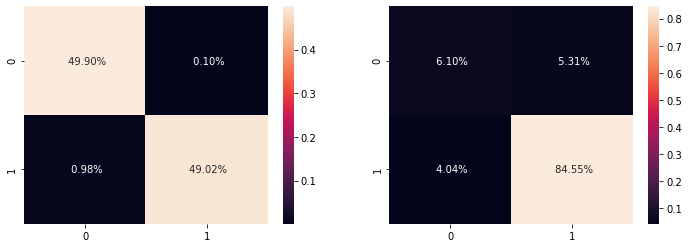

In [86]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
# confusion matrix for train set
cm_train = confusion_matrix(y_train_os, y_pred_train)
sns.heatmap(cm_train/np.sum(cm_train), annot=True , fmt = ' .2%')
# help(metrics.confusion_matrix)

plt.subplot(1,2,2)
# confusion matrix for the test data
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test/np.sum(cm_test), annot=True , fmt = ' .2%')

plt.show()

In [87]:
# storing the values in variables  

#For train set
TN_tr = cm_train[0, 0] 
FP_tr = cm_train[0, 1]
FN_tr = cm_train[1, 0]
TP_tr = cm_train[1, 1]

#for test set
TN = cm_test[0, 0]
FP = cm_test[0, 1]
FN = cm_test[1, 0]
TP = cm_test[1, 1]


In [88]:
#Calculating the Sensitivity for train and test set
sensitivity_tr = TP_tr / float(FN_tr + TP_tr)
print("sensitivity for train set: ",sensitivity_tr)
sensitivity = TP / float(FN + TP)
print("sensitivity for test set: ",sensitivity)

sensitivity for train set:  0.9803303629645729
sensitivity for test set:  0.9544413336726902


In [89]:
#specificity for test and train set. 
specificity_tr = TN_tr / float(TN_tr + FP_tr)
print("specificity for train set: ",specificity_tr)
specificity = TN / float(TN + FP)
print("specificity for test set: ",specificity)

specificity for train set:  0.9980982395131494
specificity for test set:  0.5345849802371542


<font color='red'>As you can see here that the value of specificity has increased hence, you need to use oversampling method.</font>

<font color='brown'>**Logistic Regression Model: Smote**</font>


In [90]:
# Split test and train
seed = 50 

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

In [91]:
X_train = pd.DataFrame(X_train).iloc[:,0].tolist()

In [60]:
X_train_transformed = word_vectorizer.transform(X_train)
X_test_transformed = word_vectorizer.transform(X_test.tolist())

In [62]:
counter = Counter(y_train)
print('Before',counter)

# oversampling the train dataset using SMOTE
smt = over_sampling.SMOTE()
X_train_sm,y_train_sm = smt.fit_resample(X_train_transformed,y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({1: 18404, 0: 2292})
After Counter({1: 18404, 0: 18404})


In [99]:
# Building the Logistic Regression model
time1 = time.time()

logit = LogisticRegression()
logit.fit(X_train_sm,y_train_sm)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 6.59 seconds


In [100]:
# Prediction Train Data
y_pred_train= logit.predict(X_train_sm)

#Model Performance on Train Dataset
print("Logistic Regression accuracy", accuracy_score(y_pred_train, y_train_sm))
print(classification_report(y_pred_train, y_train_sm))

Logistic Regression accuracy 0.988833949141491
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     18735
           1       0.98      1.00      0.99     18073

    accuracy                           0.99     36808
   macro avg       0.99      0.99      0.99     36808
weighted avg       0.99      0.99      0.99     36808



In [101]:
# Prediction Test Data
y_pred_test = logit.predict(X_test_transformed)

print("Logistic Regression accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))
print(confusion_matrix(y_pred_test, y_test))

Logistic Regression accuracy 0.9056369785794814
              precision    recall  f1-score   support

           0       0.54      0.60      0.57       917
           1       0.95      0.94      0.95      7953

    accuracy                           0.91      8870
   macro avg       0.75      0.77      0.76      8870
weighted avg       0.91      0.91      0.91      8870

[[ 546  371]
 [ 466 7487]]


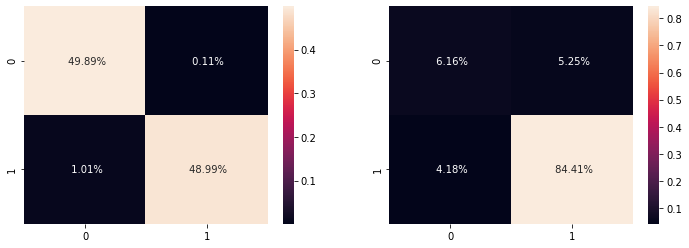

In [103]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
# confusion matrix for train set
cm_train = confusion_matrix(y_train_sm, y_pred_train)
sns.heatmap(cm_train/np.sum(cm_train), annot=True , fmt = ' .2%')
# help(metrics.confusion_matrix)

plt.subplot(1,2,2)
# confusion matrix for the test data
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test/np.sum(cm_test), annot=True , fmt = ' .2%')

plt.show()

In [104]:
# storing the values in variables  

#For train set
TN_tr = cm_train[0, 0] 
FP_tr = cm_train[0, 1]
FN_tr = cm_train[1, 0]
TP_tr = cm_train[1, 1]

#for test set
TN = cm_test[0, 0]
FP = cm_test[0, 1]
FN = cm_test[1, 0]
TP = cm_test[1, 1]


In [105]:
#Calculating the Sensitivity for train and test set
sensitivity_tr = TP_tr / float(FN_tr + TP_tr)
print("sensitivity for train set: ",sensitivity_tr)
sensitivity = TP / float(FN + TP)
print("sensitivity for test set: ",sensitivity)

sensitivity for train set:  0.9798413388393827
sensitivity for test set:  0.9527869686943242


In [106]:
#specificity for test and train set. 
specificity_tr = TN_tr / float(TN_tr + FP_tr)
print("specificity for train set: ",specificity_tr)
specificity = TN / float(TN + FP)
print("specificity for test set: ",specificity)

specificity for train set:  0.9978265594435992
specificity for test set:  0.5395256916996047


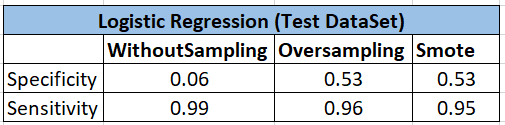

## <font color='blue'>Naive Bayes</font>

<font color='brown'>**Naive Bayes Model: Oversampling**</font>

In [54]:
y_train.value_counts()

user_sentiment
1    18404
0     2292
Name: count, dtype: int64

In [58]:
# Oversampling the dataset.
X_train_os, y_train_os = ros.fit_resample(pd.DataFrame(X_train), pd.Series(y_train))

In [59]:
y_train_os.value_counts()

user_sentiment
1    18404
0    18404
Name: count, dtype: int64

In [60]:
type(X_train_os)

pandas.core.frame.DataFrame

In [64]:
X_train_os = pd.DataFrame(X_train_os).iloc[:,0].tolist()

In [65]:
type(X_train_os)

list

In [66]:
# transforming the train and test datasets

X_train_transformed = word_vectorizer.transform(X_train_os)
X_test_transformed = word_vectorizer.transform(X_test.tolist())

In [79]:
X_train_transformed

<36808x374010 sparse matrix of type '<class 'numpy.float64'>'
	with 1577167 stored elements in Compressed Sparse Row format>

In [74]:
time1 = time.time()

mnb = MultinomialNB()
mnb.fit(X_train_transformed,y_train_os)


time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 0.07 seconds


In [80]:
# Prediction Train Data
y_pred_train = mnb.predict(X_train_transformed)

print("Naive Bayes accuracy", accuracy_score(y_pred_train , y_train_os))
print(classification_report(y_pred_train , y_train_os))

Naive Bayes accuracy 0.9816615953053685
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     18953
           1       0.97      1.00      0.98     17855

    accuracy                           0.98     36808
   macro avg       0.98      0.98      0.98     36808
weighted avg       0.98      0.98      0.98     36808



In [81]:
# Prediction Test Data
y_pred_test  = mnb.predict(X_test_transformed)

print("Naive Bayes accuracy", accuracy_score(y_pred_test , y_test))
print(classification_report(y_pred_test , y_test))

Naive Bayes accuracy 0.8591882750845546
              precision    recall  f1-score   support

           0       0.56      0.41      0.48      1371
           1       0.90      0.94      0.92      7499

    accuracy                           0.86      8870
   macro avg       0.73      0.68      0.70      8870
weighted avg       0.85      0.86      0.85      8870



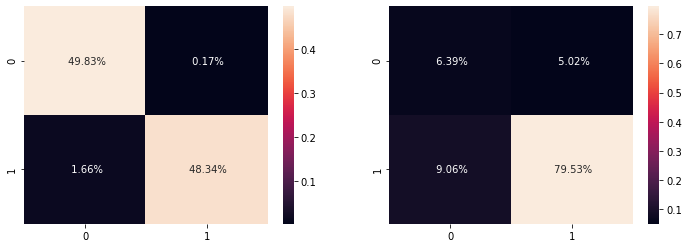

In [82]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
# confusion matrix for train set
cm_train = confusion_matrix(y_train_os, y_pred_train)
sns.heatmap(cm_train/np.sum(cm_train), annot=True , fmt = ' .2%')
# help(metrics.confusion_matrix)

plt.subplot(1,2,2)
# confusion matrix for the test data
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test/np.sum(cm_test), annot=True , fmt = ' .2%')

plt.show()

In [83]:
# storing the values in variables  

#For train set
TN_tr = cm_train[0, 0] 
FP_tr = cm_train[0, 1]
FN_tr = cm_train[1, 0]
TP_tr = cm_train[1, 1]

#for test set
TN = cm_test[0, 0]
FP = cm_test[0, 1]
FN = cm_test[1, 0]
TP = cm_test[1, 1]


In [84]:
#Calculating the Sensitivity for train and test set
sensitivity_tr = TP_tr / float(FN_tr + TP_tr)
print("sensitivity for train set: ",sensitivity_tr)
sensitivity = TP / float(FN + TP)
print("sensitivity for test set: ",sensitivity)

sensitivity for train set:  0.966746359487068
sensitivity for test set:  0.8976838890302876


In [85]:
#specificity for test and train set. 
specificity_tr = TN_tr / float(TN_tr + FP_tr)
print("specificity for train set: ",specificity_tr)
specificity = TN / float(TN + FP)
print("specificity for test set: ",specificity)

specificity for train set:  0.9965768311236688
specificity for test set:  0.5602766798418972


## <font color='blue'>Random Forest</font>

<font color='brown'>**Random Forest Model: Oversampling** </font>

In [86]:
# Building Random Forest Model.
time1 = time.time()

classifier = RandomForestClassifier(n_estimators=50, random_state=seed, n_jobs=-1)
classifier.fit(X_train_transformed,y_train_os)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 26.67 seconds


In [89]:
# Prediction Train Data
y_pred_train= classifier.predict(X_train_transformed)

print("Random Forest Model accuracy", accuracy_score(y_pred_train, y_train_os))
print(classification_report(y_pred_train, y_train_os))

Random Forest Model accuracy 0.99994566398609
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18406
           1       1.00      1.00      1.00     18402

    accuracy                           1.00     36808
   macro avg       1.00      1.00      1.00     36808
weighted avg       1.00      1.00      1.00     36808



In [90]:
# Prediction Test Data
y_pred_test = classifier.predict(X_test_transformed)

print("Random Forest Model accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))


Random Forest Model accuracy 0.9094701240135288
              precision    recall  f1-score   support

           0       0.30      0.76      0.43       395
           1       0.99      0.92      0.95      8475

    accuracy                           0.91      8870
   macro avg       0.64      0.84      0.69      8870
weighted avg       0.96      0.91      0.93      8870



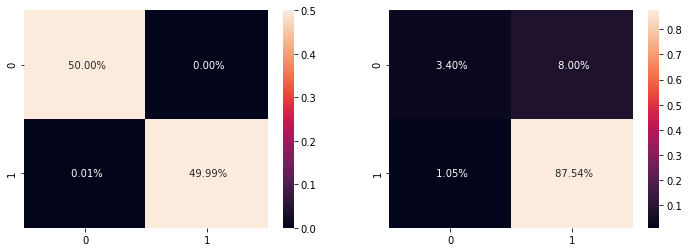

In [92]:

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)

# confusion matrix for train set
cm_train = confusion_matrix(y_train_os, y_pred_train)
sns.heatmap(cm_train/np.sum(cm_train), annot=True , fmt = ' .2%')
# help(metrics.confusion_matrix)

plt.subplot(1,2,2)

# confusion matrix for the test data
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test/np.sum(cm_test), annot=True , fmt = ' .2%')

plt.show()

In [93]:
# storing the values in variables  

#For train set: TN: True Negative, FP: False Positive, FN: False Negative, TP: True Positive
TN_tr = cm_train[0, 0] 
FP_tr = cm_train[0, 1]
FN_tr = cm_train[1, 0]
TP_tr = cm_train[1, 1]

#for test set
TN = cm_test[0, 0]
FP = cm_test[0, 1]
FN = cm_test[1, 0]
TP = cm_test[1, 1]


In [94]:
#Calculating the Sensitivity for train and test set
sensitivity_tr = TP_tr / float(FN_tr + TP_tr)
print("sensitivity for train set: ",sensitivity_tr)
sensitivity = TP / float(FN + TP)
print("sensitivity for test set: ",sensitivity)

sensitivity for train set:  0.9998913279721799
sensitivity for test set:  0.9881649274624587


In [95]:
#specificity for test and train set. 
specificity_tr = TN_tr / float(TN_tr + FP_tr)
print("specificity for train set: ",specificity_tr)
specificity = TN / float(TN + FP)
print("specificity for test set: ",specificity)

specificity for train set:  1.0
specificity for test set:  0.2984189723320158


## <font color='blue'>XGBoost</font>

In [100]:
time1 = time.time()

xgb = xg.XGBClassifier(n_jobs=-1)
xgb.fit(X_train_transformed,y_train_os)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 49.98 seconds


In [101]:
# Prediction Train Data
y_pred_train  = xgb.predict(X_train_transformed)

print("XGBoost Model accuracy", accuracy_score(y_pred_train, y_train_os))
print(classification_report(y_pred_train, y_train_os))

XGBoost Model accuracy 0.9428113453597045
              precision    recall  f1-score   support

           0       0.98      0.91      0.95     19907
           1       0.90      0.98      0.94     16901

    accuracy                           0.94     36808
   macro avg       0.94      0.95      0.94     36808
weighted avg       0.95      0.94      0.94     36808



In [102]:
# Prediction Test Data
y_pred_test  = xgb.predict(X_test_transformed)

print("XGBoost Model accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))

XGBoost Model accuracy 0.8634723788049605
              precision    recall  f1-score   support

           0       0.68      0.44      0.53      1583
           1       0.89      0.96      0.92      7287

    accuracy                           0.86      8870
   macro avg       0.79      0.70      0.73      8870
weighted avg       0.85      0.86      0.85      8870



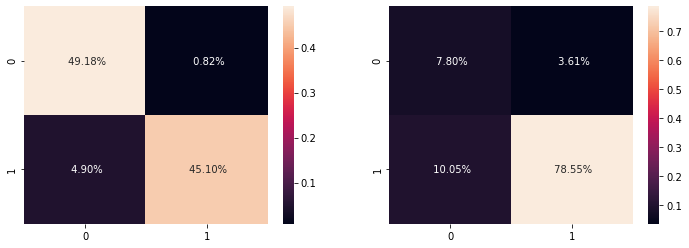

In [103]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
# confusion matrix for train set
cm_train = confusion_matrix(y_train_os, y_pred_train)
sns.heatmap(cm_train/np.sum(cm_train), annot=True , fmt = ' .2%')
# help(metrics.confusion_matrix)

plt.subplot(1,2,2)
# confusion matrix for the test data
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test/np.sum(cm_test), annot=True , fmt = ' .2%')

plt.show()

In [104]:
# storing the values in variables  

#For train set
TN_tr = cm_train[0, 0] 
FP_tr = cm_train[0, 1]
FN_tr = cm_train[1, 0]
TP_tr = cm_train[1, 1]

#for test set
TN = cm_test[0, 0]
FP = cm_test[0, 1]
FN = cm_test[1, 0]
TP = cm_test[1, 1]


In [105]:
#Calculating the Sensitivity for train and test set
sensitivity_tr = TP_tr / float(FN_tr + TP_tr)
print("sensitivity for train set: ",sensitivity_tr)
sensitivity = TP / float(FN + TP)
print("sensitivity for test set: ",sensitivity)

sensitivity for train set:  0.9019778309063247
sensitivity for test set:  0.8866123695596844


In [106]:
#specificity for test and train set. 
specificity_tr = TN_tr / float(TN_tr + FP_tr)
print("specificity for train set: ",specificity_tr)
specificity = TN / float(TN + FP)
print("specificity for test set: ",specificity)

specificity for train set:  0.9836448598130841
specificity for test set:  0.6837944664031621


## <font color='blue'>Hyper Parameter Tuning On Oversampled Data</font>

### <font color='Mocha'>**Random Forest**</font>

In [108]:
# Building Random Forest Model.
time1 = time.time()

n_estimators = [10,20,30] 
max_features = ['auto', 'sqrt']
max_depth = [4,5,6]
max_depth.append(None) # If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf_classifier = RandomForestClassifier(random_state=42)

rf_final = RandomizedSearchCV(estimator=rf_classifier, param_distributions=random_grid, n_iter=5, cv=3, 
                               verbose=2, random_state=42, n_jobs=-1)


rf_final.fit(X_train_transformed,y_train_os)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   32.3s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   42.0s finished


Time Taken: 48.52 seconds


In [109]:
rf_final.best_estimator_

RandomForestClassifier(max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=10, random_state=42)

In [110]:
# Prediction Train Data
y_pred_train= rf_final.predict(X_train_transformed)

print("Random Forest Model accuracy", accuracy_score(y_pred_train, y_train_os))
print(classification_report(y_pred_train, y_train_os))

Random Forest Model accuracy 0.9709030645511846
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     18419
           1       0.97      0.97      0.97     18389

    accuracy                           0.97     36808
   macro avg       0.97      0.97      0.97     36808
weighted avg       0.97      0.97      0.97     36808



In [111]:
# Prediction Test Data
y_pred_test = rf_final.predict(X_test_transformed)

print("Random Forest Model accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))


Random Forest Model accuracy 0.8832018038331454
              precision    recall  f1-score   support

           0       0.52      0.49      0.50      1070
           1       0.93      0.94      0.93      7800

    accuracy                           0.88      8870
   macro avg       0.72      0.71      0.72      8870
weighted avg       0.88      0.88      0.88      8870



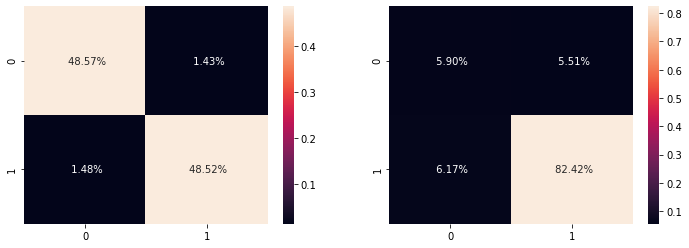

In [112]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)

# confusion matrix for train set
cm_train = confusion_matrix(y_train_os, y_pred_train)
sns.heatmap(cm_train/np.sum(cm_train), annot=True , fmt = ' .2%')
# help(metrics.confusion_matrix)

plt.subplot(1,2,2)

# confusion matrix for the test data
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test/np.sum(cm_test), annot=True , fmt = ' .2%')

plt.show()

In [113]:
# storing the values in variables  

#For train set: TN: True Negative, FP: False Positive, FN: False Negative, TP: True Positive
TN_tr = cm_train[0, 0] 
FP_tr = cm_train[0, 1]
FN_tr = cm_train[1, 0]
TP_tr = cm_train[1, 1]

#for test set
TN = cm_test[0, 0]
FP = cm_test[0, 1]
FN = cm_test[1, 0]
TP = cm_test[1, 1]


In [114]:
#Calculating the Sensitivity for train and test set
sensitivity_tr = TP_tr / float(FN_tr + TP_tr)
print("sensitivity for train set: ",sensitivity_tr)
sensitivity = TP / float(FN + TP)
print("sensitivity for test set: ",sensitivity)

sensitivity for train set:  0.9704955444468594
sensitivity for test set:  0.9303894120641385


In [115]:
#specificity for test and train set. 
specificity_tr = TN_tr / float(TN_tr + FP_tr)
print("specificity for train set: ",specificity_tr)
specificity = TN / float(TN + FP)
print("specificity for test set: ",specificity)

specificity for train set:  0.9713105846555097
specificity for test set:  0.516798418972332


### <font color='Mocha'>**XGBoost**</font>

In [117]:
# Building Xgboost Model.
time1 = time.time()

import xgboost as xgb 
n_estimators = [10,15,20,25,30] 
max_features = ['auto', 'sqrt']
max_depth = [4,5,6]
max_depth.append(None) # If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

xgb = xgb.XGBClassifier(n_jobs=-1)

xgb_final = RandomizedSearchCV(estimator=xgb, param_distributions=random_grid, n_iter=5, cv=3, 
                               verbose=2, random_state=42, n_jobs=-1)


xgb_final.fit(X_train_transformed,y_train_os)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.0min remaining:   30.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.3min finished


Time Taken: 173.81 seconds


In [118]:
xgb_final.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_features='auto',
              max_leaves=None, min_child_weight=None, min_samples_leaf=4,
              min_samples_split=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, ...)

In [121]:
# Prediction Train Data
y_pred_train= xgb_final.predict(X_train_transformed)

print("Xgboost Forest Model accuracy", accuracy_score(y_pred_train, y_train_os))
print(classification_report(y_pred_train, y_train_os))

Xgboost Forest Model accuracy 0.8783416648554662
              precision    recall  f1-score   support

           0       0.91      0.86      0.88     19558
           1       0.85      0.90      0.87     17250

    accuracy                           0.88     36808
   macro avg       0.88      0.88      0.88     36808
weighted avg       0.88      0.88      0.88     36808



In [122]:
# Prediction Test Data
y_pred_test = xgb_final.predict(X_test_transformed)

print("Xgboost Model accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))


Xgboost Model accuracy 0.8259301014656144
              precision    recall  f1-score   support

           0       0.73      0.37      0.49      2000
           1       0.84      0.96      0.90      6870

    accuracy                           0.83      8870
   macro avg       0.78      0.66      0.69      8870
weighted avg       0.81      0.83      0.80      8870



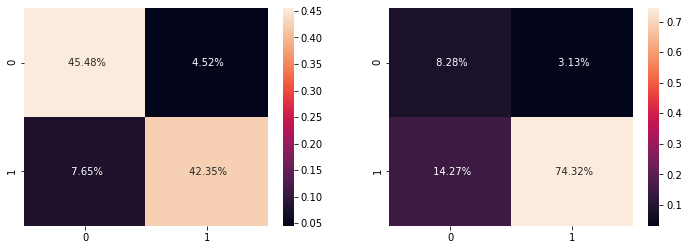

In [123]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)

# confusion matrix for train set
cm_train = confusion_matrix(y_train_os, y_pred_train)
sns.heatmap(cm_train/np.sum(cm_train), annot=True , fmt = ' .2%')
# help(metrics.confusion_matrix)

plt.subplot(1,2,2)

# confusion matrix for the test data
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test/np.sum(cm_test), annot=True , fmt = ' .2%')

plt.show()

In [124]:
# storing the values in variables  

#For train set: TN: True Negative, FP: False Positive, FN: False Negative, TP: True Positive
TN_tr = cm_train[0, 0] 
FP_tr = cm_train[0, 1]
FN_tr = cm_train[1, 0]
TP_tr = cm_train[1, 1]

#for test set
TN = cm_test[0, 0]
FP = cm_test[0, 1]
FN = cm_test[1, 0]
TP = cm_test[1, 1]


In [125]:
#Calculating the Sensitivity for train and test set
sensitivity_tr = TP_tr / float(FN_tr + TP_tr)
print("sensitivity for train set: ",sensitivity_tr)
sensitivity = TP / float(FN + TP)
print("sensitivity for test set: ",sensitivity)

sensitivity for train set:  0.8469897848293849
sensitivity for test set:  0.8388903028760499


In [126]:
#specificity for test and train set. 
specificity_tr = TN_tr / float(TN_tr + FP_tr)
print("specificity for train set: ",specificity_tr)
specificity = TN / float(TN + FP)
print("specificity for test set: ",specificity)

specificity for train set:  0.9096935448815475
specificity for test set:  0.7252964426877471


## <font color='red'> Machine Learning - Sentiment Model Evaluation Summary</font>

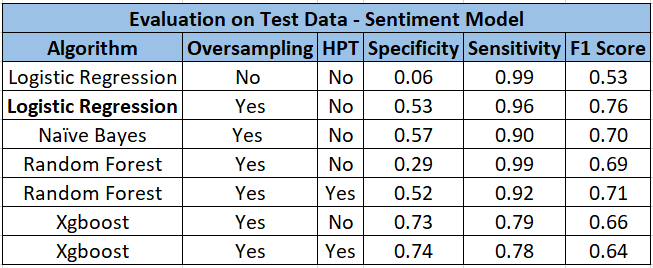

## <font color='blue'>Recommendation System</font>

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29566 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              29566 non-null  object
 1   brand           29566 non-null  object
 2   categories      29566 non-null  object
 3   manufacturer    29566 non-null  object
 4   prod_name       29566 non-null  object
 5   reviews_date    29566 non-null  object
 6   reviews_rating  29566 non-null  int64 
 7   reviews_text    29566 non-null  object
 8   reviews_title   29566 non-null  object
 9   userID          29566 non-null  object
 10  user_sentiment  29566 non-null  int64 
 11  Reviews         29566 non-null  object
 12  Reviws          29566 non-null  object
dtypes: int64(2), object(11)
memory usage: 3.2+ MB


In [55]:
# Getting only relevant columns
df1 = df[["userID","reviews_rating","prod_name"]]

In [56]:
#Check the NULL count:
df1.isnull().any()

userID            False
reviews_rating    False
prod_name         False
dtype: bool

In [57]:
df1.head(2)

,userID,reviews_rating,prod_name
0,joshua,5,Pink Friday: Roman Reloaded Re-Up (w/dvd)
1,dorothy w,5,Lundberg Organic Cinnamon Toast Rice Cakes


In [58]:
train, test = train_test_split(df1, test_size=0.30, random_state=31)

In [59]:
print(train.shape)
print(test.shape)

(20696, 3)
(8870, 3)


#### <font color='brown'>Dummy Train creation for end prediciton.</font>

`These dataset will be used for prediction and evaluation.`

`Dummy train will be used later for prediction of the movies which has not been rated by the user. To ignore the movies rated by the user, we will mark it as 0 during prediction. The movies not rated by user is marked as 1 for prediction.`

In [60]:
dummy_train  = train.copy()

In [61]:
dummy_train.head(5)

,userID,reviews_rating,prod_name
29334,jhazobeaute23,4,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz
18672,abret,4,Clorox Disinfecting Bathroom Cleaner
14532,hgandee,5,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total
25152,bleepibityboop,5,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd
9773,85lisa,5,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total


In [62]:
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x : 0 if x>=1 else 1)

In [63]:
dummy_train.head(5)

,userID,reviews_rating,prod_name
29334,jhazobeaute23,0,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz
18672,abret,0,Clorox Disinfecting Bathroom Cleaner
14532,hgandee,0,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total
25152,bleepibityboop,0,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd
9773,85lisa,0,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total


In [64]:
dummy_train = dummy_train.pivot_table(index='userID',columns='prod_name',values='reviews_rating').fillna(1)

In [65]:
dummy_train.shape

(18061, 233)

### <font color='purple'>User Similarity Matrix</font>

 #### Using adjusted Cosine

`We are not removing the NaN values and calculating the mean only for the movies rated by the user`

In [66]:
# Make the user- item matrix representaion of train dataset.
user_based_matrix = train.pivot_table(index='userID',columns='prod_name',values='reviews_rating')

In [67]:
user_based_matrix.shape

(18061, 233)

`Normalising the rating of the products for each user around 0 mean`

In [68]:
mean = np.nanmean(user_based_matrix,axis=1)

In [69]:
mean.shape

(18061,)

In [70]:
df_subtracted = (user_based_matrix.T - mean).T

In [71]:
df_subtracted

prod_name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 pk",Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,Concept Housewares 36 Natural Wood ceiling mounted pot rack,"Coty Airspun Face Powder, Translucent Extra Coverage","Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Gain Original Scent Liquid Fabric Softener 129 Oz,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1,"Heinz Tomato Ketchup, 38oz",Heiress (dvd),Herr's Baked Cheese Curls,High-Dome Floor Door Stop,Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Home H

**Finding cosine similarity**

In [72]:
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0),metric='cosine')

In [73]:
user_correlation[np.isnan(user_correlation)]=0

In [74]:
user_correlation.shape

(18061, 18061)

### <font color='brown'>Prediction</font>

`Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. `

In [75]:
user_correlation[user_correlation<0]=0

**Rating predicted by the user (for movies rated as well as not rated) is the weighted sum of correlation with the movie rating (as present in the rating dataset).**

In [76]:
user_predicted_ratings = np.dot(user_correlation, user_based_matrix.fillna(0))
user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [77]:
user_predicted_ratings.shape

(18061, 233)

**Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero.**

In [78]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

prod_name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 pk",Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,Concept Housewares 36 Natural Wood ceiling mounted pot rack,"Coty Airspun Face Powder, Translucent Extra Coverage","Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Gain Original Scent Liquid Fabric Softener 129 Oz,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1,"Heinz Tomato Ketchup, 38oz",Heiress (dvd),Herr's Baked Cheese Curls,High-Dome Floor Door Stop,Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Home H

### <font color='green'>Item Based Similarity</font>

#### **Using adjusted Cosine**

**Using Correlation**

`Taking the transpose of the rating matrix to normalize the rating around the mean for different movie ID. In the user based similarity, we had taken mean for each user intead of each movie.`

In [86]:
train

,userID,reviews_rating,prod_name
29334,jhazobeaute23,4,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz
18672,abret,4,Clorox Disinfecting Bathroom Cleaner
14532,hgandee,5,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total
25152,bleepibityboop,5,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd
9773,85lisa,5,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total
...,...,...,...
3781,zarah,5,Sabre 2 Pack Door And Window Alarm
15055,johnh96813,5,"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter"
27916,srut,5,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)
27027,mike,5,Jason Aldean - They Don't Know


In [87]:
item_based_matrix = train.pivot_table(index='userID',columns='prod_name',values='reviews_rating')

In [88]:
item_based_matrix.shape

(18061, 233)

In [107]:
(item_based_matrix.shape

(233, 18061)

**Normalising the movie rating for each movie**

In [111]:
mean = np.nanmean(item_based_matrix, axis=1)
df_subtracted = (item_based_matrix.T-mean)

In [113]:
df_subtracted.head()

userID,00dog3,01impala,02dakota,0325home,06stidriver,08dallas,09mommy11,1085,10ten,1143mom,1234,1234561,1234567,1234asdf,123cat123,123rs,123soccermom,123too,12cass12,132457,13ld,13ram,1421nikki,143st,148maine,1515,15425shopper,170361eggs,1753,18612,1863philly,1943,1968bear,1992firebirdgirl,19granny,1boomer,1cadet,1chynna,1clean1,1cocoafan,1derpet1,1disappoint,1friendlycat,1gamer,1gussy,1happymom,1hotmama,1izzy1,1jc1,1jodie,1kindword,1movielover2,1officegal,1okc2thunder3up4,1scooby1,1shop,1sonny,1stcavdivision,1stgrade,1stlady,1sungirl,1texasmom,1tomg,1vgarcia,1wildbill2l,1witch,2011pink2011,2013bestbuyer,2014bestbuys,2015mom,2016,2016home,2062351337,20crafter16,210tundra,2175046722,21please,23jen,2455,24hrstoneroses,2532674594,25happyshopper,262jennifer,2689,2827,28green,295259,2athome,2bgreen,2busy4u,2choclabs,2cutekids,2dobies,2ds4es14,2forhokies,2rogersmakearight,2sweetdaisies,2thumbsup,2total,30103,...,yoly,yoma,yonino,yooper,yorkielvr,yorkster88,yoshi,yoski,yosuerte,youjon,youknowit459,youlooksolovely,younggrannie62,youronereviewer,youthfulone,yoyo1245,yozer29,yram,yrina03,yshan,ythelastman89,yttric,yucky111,yummy,yumyum,yvonne,yyz2112123,yzkgsx,z12345,z33pisces,zacharysaunt,zachizz,zachsmom,zacroxs,zaibo,zak08,zakkwylde29,zakkzakk,zamanda,zanarkandruinsx2,zanay,zanzan73,zapaduh,zapman,zara0215,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zee74,zeek,zeek09,zeeleader,zegan,zelyas,zenanuts,zenmon,zeramm,zero,zetamom,zhio,zibber23,ziggy,zillafan,zillanator,zimmeyb,zina911,zinnian,zipflip,zipp,zipper,zippity,zippy,zitro,zittles,zkondrk,zmikez,zmom,znxfyt,zod10,zoe1988,zoeellasca,zoeyny,zombie,zombiedad80,zombiegirl22,zombiekiller14,zone,zookeeper,zoso60,zout22389,zowie,zpalma,zsazsa,zt313,zubb,zulaa118,zzdiane
prod_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

**Finding the cosine similarity.**

In [120]:
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [121]:
item_correlation.shape

(233, 233)

**Filtering the correlation only for which the value is greater than 0. (Positively correlated)**

In [122]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [123]:
item_correlation.shape

(233, 233)

### <font color='brown'>Prediction</font>

In [128]:
item_predicted_ratings = np.dot((item_based_matrix.fillna(0)),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.13003463, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.08708366,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.14513943,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.12071328, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [129]:
item_predicted_ratings.shape

(18061, 233)

#### Filtering the rating only for the products not rated by the user for recommendation

In [130]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

prod_name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 pk",Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,Concept Housewares 36 Natural Wood ceiling mounted pot rack,"Coty Airspun Face Powder, Translucent Extra Coverage","Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Gain Original Scent Liquid Fabric Softener 129 Oz,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1,"Heinz Tomato Ketchup, 38oz",Heiress (dvd),Herr's Baked Cheese Curls,High-Dome Floor Door Stop,Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Home H

### <font color='blue'>Evaluation: User vs Item Based System</font>

`Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user.`

 **Using User Similarity**

In [139]:
common = test[test.userID.isin(train.userID)]
common.shape

(2026, 3)

In [140]:
common.head()

,userID,reviews_rating,prod_name
17353,mars57,4,"Just For Men Touch Of Gray Gray Hair Treatment, Black T-55"
8539,nitmom,5,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total
26646,byamazon customer,5,"Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz"
29003,ivywxy,3,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz
8651,bonnieo,5,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total


In [141]:
common_user_based_matrix = common.pivot_table(index='userID', columns='prod_name', values='reviews_rating')

In [144]:
common_user_based_matrix.shape

(1698, 111)

In [145]:
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [146]:
user_correlation_df = pd.DataFrame(user_correlation)

In [150]:
df_subtracted.T

prod_name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 pk",Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,Concept Housewares 36 Natural Wood ceiling mounted pot rack,"Coty Airspun Face Powder, Translucent Extra Coverage","Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Gain Original Scent Liquid Fabric Softener 129 Oz,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1,"Heinz Tomato Ketchup, 38oz",Heiress (dvd),Herr's Baked Cheese Curls,High-Dome Floor Door Stop,Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Home H

In [151]:
user_correlation_df['reviews_username'] = (df_subtracted).T.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,17961,17962,17963,17964,17965,17966,17967,17968,17969,17970,17971,17972,17973,17974,17975,17976,17977,17978,17979,17980,17981,17982,17983,17984,17985,17986,17987,17988,17989,17990,17991,17992,17993,17994,17995,17996,17997,17998,17999,18000,18001,18002,18003,18004,18005,18006,18007,18008,18009,18010,18011,18012,18013,18014,18015,18016,18017,18018,18019,18020,18021,18022,18023,18024,18025,18026,18027,18028,18029,18030,18031,18032,18033,18034,18035,18036,18037,18038,18039,18040,18041,18042,18043,18044,18045,18046,18047,18048,18049,18050,18051,18052,18053,18054,18055,18056,18057,18058,18059,18060
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [153]:
list_name = common.userID.tolist()

user_correlation_df.columns = (df_subtracted).T.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [154]:
user_correlation_df_1

,00dog3,01impala,02dakota,0325home,06stidriver,08dallas,09mommy11,1085,10ten,1143mom,1234,1234561,1234567,1234asdf,123cat123,123rs,123soccermom,123too,12cass12,132457,13ld,13ram,1421nikki,143st,148maine,1515,15425shopper,170361eggs,1753,18612,1863philly,1943,1968bear,1992firebirdgirl,19granny,1boomer,1cadet,1chynna,1clean1,1cocoafan,1derpet1,1disappoint,1friendlycat,1gamer,1gussy,1happymom,1hotmama,1izzy1,1jc1,1jodie,1kindword,1movielover2,1officegal,1okc2thunder3up4,1scooby1,1shop,1sonny,1stcavdivision,1stgrade,1stlady,1sungirl,1texasmom,1tomg,1vgarcia,1wildbill2l,1witch,2011pink2011,2013bestbuyer,2014bestbuys,2015mom,2016,2016home,2062351337,20crafter16,210tundra,2175046722,21please,23jen,2455,24hrstoneroses,2532674594,25happyshopper,262jennifer,2689,2827,28green,295259,2athome,2bgreen,2busy4u,2choclabs,2cutekids,2dobies,2ds4es14,2forhokies,2rogersmakearight,2sweetdaisies,2thumbsup,2total,30103,...,yoly,yoma,yonino,yooper,yorkielvr,yorkster88,yoshi,yoski,yosuerte,youjon,youknowit459,youlooksolovely,younggrannie62,youronereviewer,youthfulone,yoyo1245,yozer29,yram,yrina03,yshan,ythelastman89,yttric,yucky111,yummy,yumyum,yvonne,yyz2112123,yzkgsx,z12345,z33pisces,zacharysaunt,zachizz,zachsmom,zacroxs,zaibo,zak08,zakkwylde29,zakkzakk,zamanda,zanarkandruinsx2,zanay,zanzan73,zapaduh,zapman,zara0215,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zee74,zeek,zeek09,zeeleader,zegan,zelyas,zenanuts,zenmon,zeramm,zero,zetamom,zhio,zibber23,ziggy,zillafan,zillanator,zimmeyb,zina911,zinnian,zipflip,zipp,zipper,zippity,zippy,zitro,zittles,zkondrk,zmikez,zmom,znxfyt,zod10,zoe1988,zoeellasca,zoeyny,zombie,zombiedad80,zombiegirl22,zombiekiller14,zone,zookeeper,zoso60,zout22389,zowie,zpalma,zsazsa,zt313,zubb,zulaa118,zzdiane
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288675,0.57735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [155]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [157]:
user_correlation_df_2

reviews_username,1234,1234567,1943,1witch,37f5p,4cloroxl,4djs,8ellie24,aac06002,aaron,abby,abc,abcdef,abcgator,abcssds,abismomy,abret,ace24,acg1,acv4217,adam,adamsmom,adelynsmom,adizzione,adriana,adriana9999,aep1010,agmt,ahjohnson1983,aimee,aisha,aj1135,ajay,ajcrossover11,ajune,akporter84,aktcharlotte,alarm,alena125,alex,ali1353,alice,alix p,allan6048,allie123,allison33,ally,allyj1984,alredhouse,alta,alvin,amanda,amanda13,amandamueller,amber,amber0528,amgo2,amlyke,ammi,amsmes26,amy77,amyw333,anas,andi,andrea,andrew,andy,ang32,angc,angel,angel65481,angie,angie0104,angiesmessykids,anita,anna,anna1202,annalou75,annie4u,annoymous,anonymous 1,anthony,april,aprilg87,aprilgoddess,arcticfox,arlandry,arno,ash23,ash4,ashleyden,ashleyfawne,ashleylysette,ashsmash,asohn,atacjj,athenabear,atid,augale,aunt ape,...,tiff4199,tiffany,tiffany1167,tifflet10,tigmommy,timothy,tina,tina40,tina71,tinaj,tinanmel,tjzmom,toddster7,tominator,tommty41,toni,tony,tony1,topaz0502,torrie,toshcal,tracie,tracy,trav,trcvngrn,tredsoftball,treese,trish626,trisha,trpfeffer3,ttia,tucker65,turi,twebb,tweetyanne,typist,ulcunique,unhappy cus to mer,unicorn351,usaf1,val214,valerie,valeriecherry,vallink,vanessavast,vanita80,vccaan,veebee3,vette,vick88,vicki,vickie,vicocious,victor,victoria,victoria harris,viking80,vikki,vivi37,vivienne,viviln,vkay,voxemluth,vyph,vypkf0,wackibanan,wally,warren,wasabi42,wcgirl,wendy2245,weston t,whome,wildchild23,wildman,windowkitty,wise,wizard,wjb1,wolfie,wolverine,wonderwoman,woody,woohoo,worm,xcoupon,yamel97,yaquiv,yayatex,yesseniaw22,yeyo,yohnie1,yorkielvr,yshan,yucky111,yummy,zapman,zipper,zippy,zmom
1234,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.456435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.589256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288675,0.0
1234567,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1943,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0

In [156]:
user_correlation_df_3 = user_correlation_df_2.T

In [158]:
user_correlation_df_3

,1234,1234567,1943,1witch,37f5p,4cloroxl,4djs,8ellie24,aac06002,aaron,abby,abc,abcdef,abcgator,abcssds,abismomy,abret,ace24,acg1,acv4217,adam,adamsmom,adelynsmom,adizzione,adriana,adriana9999,aep1010,agmt,ahjohnson1983,aimee,aisha,aj1135,ajay,ajcrossover11,ajune,akporter84,aktcharlotte,alarm,alena125,alex,ali1353,alice,alix p,allan6048,allie123,allison33,ally,allyj1984,alredhouse,alta,alvin,amanda,amanda13,amandamueller,amber,amber0528,amgo2,amlyke,ammi,amsmes26,amy77,amyw333,anas,andi,andrea,andrew,andy,ang32,angc,angel,angel65481,angie,angie0104,angiesmessykids,anita,anna,anna1202,annalou75,annie4u,annoymous,anonymous 1,anthony,april,aprilg87,aprilgoddess,arcticfox,arlandry,arno,ash23,ash4,ashleyden,ashleyfawne,ashleylysette,ashsmash,asohn,atacjj,athenabear,atid,augale,aunt ape,...,tiff4199,tiffany,tiffany1167,tifflet10,tigmommy,timothy,tina,tina40,tina71,tinaj,tinanmel,tjzmom,toddster7,tominator,tommty41,toni,tony,tony1,topaz0502,torrie,toshcal,tracie,tracy,trav,trcvngrn,tredsoftball,treese,trish626,trisha,trpfeffer3,ttia,tucker65,turi,twebb,tweetyanne,typist,ulcunique,unhappy cus to mer,unicorn351,usaf1,val214,valerie,valeriecherry,vallink,vanessavast,vanita80,vccaan,veebee3,vette,vick88,vicki,vickie,vicocious,victor,victoria,victoria harris,viking80,vikki,vivi37,vivienne,viviln,vkay,voxemluth,vyph,vypkf0,wackibanan,wally,warren,wasabi42,wcgirl,wendy2245,weston t,whome,wildchild23,wildman,windowkitty,wise,wizard,wjb1,wolfie,wolverine,wonderwoman,woody,woohoo,worm,xcoupon,yamel97,yaquiv,yayatex,yesseniaw22,yeyo,yohnie1,yorkielvr,yshan,yucky111,yummy,zapman,zipper,zippy,zmom
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.456435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.589256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288675,0.0
1234567,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1943,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,

**The products not rated by user is marked as 0 for evaluation. And make the user- item matrix representaion.**

In [159]:
user_correlation_df_3[user_correlation_df_3<0]=0

In [160]:
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 1.15470054, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.75201365, 0.        , ..., 2.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

`Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train`

In [161]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='userID', columns='prod_name', values='reviews_rating').fillna(0)

In [162]:
dummy_test.shape

(1698, 111)

In [163]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [164]:
common_user_predicted_ratings.head()

prod_name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),"All,bran Complete Wheat Flakes, 18 Oz.","Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets","Burt's Bees Lip Shimmer, Raisin",Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Coty Airspun Face Powder, Translucent Extra Coverage","Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Hollywood Beauty Olive Cholesterol,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans","Iman Second To None Stick Foundation, Clay 1",J.a. Henckels International 4-Pc Everedge Plus Steak Knife Set,Jason Aldean - They Don't Know,"Johnson's Baby Bubble Bath and Wash, 15oz",Jolly Time Select Premium Yellow Pop Corn,"Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",K-Y Love Sensuality Pleasure Gel,Kendall Comforter And Sheet Set (twin) Aqua - 7pc,Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,L'oreal Paris Advanced Hairstyle Boost It High Lift Creation Spray,"Lundberg Wehani Rice, 25lb","Lysol Concentrate Deodorizing Cleaner, Original Scent",Meguiar's Deep Crystal Car Wash 64-Oz.,Meguiar's Ultimate Quik Detailer 22-Oz.,Meguiars Interior Detailer Wipes 25ct,Mike Dave Need Wedding Dates (dvd + Digital),Mrs. Meyer's Lemon Verbena Surface Scrub,Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz,"Musselman Apple Sauce, Cinnamon, 48oz",My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),Nearly Natural 5.5' Bamboo W/decorative Planter,Nexxus Exxtra Gel Style Creation Sculptor,"Ogx Conditioner, Hydrating Teatree Mint",Olay Regenerist Deep Hydration Regenerating Cream,Orajel Maximum Strength Toothache Pain Relief Liquid,Pantene Pro-V Expert Collection Age Defy Conditioner,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),"Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Medium, LWS-127201","Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",Pleasant Hearth Diamond Fireplace Screen - Espresso,Pos

### Calculating the RMSE for only the movies rated by user. For RMSE, normalising the rating to (1,5) range.

In [168]:
X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

MinMaxScaler(feature_range=(1, 5))


In [169]:
y

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [170]:
common_ = common.pivot_table(index='userID', columns='prod_name', values='reviews_rating')

In [171]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

### <font color='brown'>Using Item Similarity</font>

In [177]:
common =  test[test.prod_name.isin(train.prod_name)]

common.prod_name.nunique()
common.shape

(8851, 3)

In [178]:
common.head(1)

,userID,reviews_rating,prod_name
132,6623443094,4,Olay Regenerist Deep Hydration Regenerating Cream


In [179]:
common_item_based_matrix = common.pivot_table(index='userID', columns='prod_name', values='reviews_rating').T

In [180]:
common_item_based_matrix.shape

(176, 8250)

In [181]:
item_correlation_df = pd.DataFrame(item_correlation)

In [182]:
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0

In [183]:
item_correlation_df['reviews_items'] = df_subtracted.index
item_correlation_df.set_index('reviews_items',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232
reviews_items,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0

In [184]:
common_item_based_matrix.shape

(176, 8250)

In [185]:
list_name = common.prod_name.tolist()

In [186]:
item_correlation_df.columns = df_subtracted.index.tolist()
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [187]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
item_correlation_df_3 = item_correlation_df_2.T

In [190]:
item_correlation_df_3[item_correlation_df_3<0]=0
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.11611154, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [189]:
common_item_predicted_ratings.shape

(176, 8250)

**Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train**

In [191]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='userID', columns='prod_name', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [192]:
common_ = common.pivot_table(index='userID', columns='prod_name', values='reviews_rating').T

In [193]:
common

,userID,reviews_rating,prod_name
132,6623443094,4,Olay Regenerist Deep Hydration Regenerating Cream
5882,bbmj,5,Red (special Edition) (dvdvideo)
17353,mars57,4,"Just For Men Touch Of Gray Gray Hair Treatment, Black T-55"
15361,tjs38,5,Orajel Maximum Strength Toothache Pain Relief Liquid
10574,danadane72375,5,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total
...,...,...,...
5580,bob1953,5,"Australian Gold Exotic Blend Lotion, SPF 4"
21272,not happy,1,Nexxus Exxtra Gel Style Creation Sculptor
19189,fatima,5,Clorox Disinfecting Bathroom Cleaner
17628,lynda,4,"Coty Airspun Face Powder, Translucent Extra Coverage"


In [194]:

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [195]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

### <font color='blue'>Recommendation</font>

In [197]:
user_final_rating

prod_name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 pk",Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,Concept Housewares 36 Natural Wood ceiling mounted pot rack,"Coty Airspun Face Powder, Translucent Extra Coverage","Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Gain Original Scent Liquid Fabric Softener 129 Oz,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1,"Heinz Tomato Ketchup, 38oz",Heiress (dvd),Herr's Baked Cheese Curls,High-Dome Floor Door Stop,Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Home H

In [198]:
# save the respective files Pickle 
import pickle
pickle.dump(user_final_rating,open('user_final_rating.pkl','wb'))
user_final_rating =  pickle.load(open('user_final_rating.pkl', 'rb'))

In [199]:
# Using User based similarity system as its RMSE value is less than item based similarity system.
user_input = input("Enter your user name")
print(user_input)

Enter your user namejoshua
joshua


In [200]:
# Recommending the Top 20 products to the user.
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

prod_name
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                    8.660254
Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular                            3.333333
Pleasant Hearth Diamond Fireplace Screen - Espresso                                3.333333
Tostitos Bite Size Tortilla Chips                                                  3.333333
Ragu Traditional Pasta Sauce                                                       3.333333
Chester's Cheese Flavored Puffcorn Snacks                                          2.927700
Clorox Disinfecting Bathroom Cleaner                                               2.927700
Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)                      2.886751
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)                              2.886751
Reebok Classic Leather Running Shoes - White (Men)                                 2.886751
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)          

**Filtering out the Top 5 recommendation items based on Logistic Regression ML model.**

In [203]:
# save the respective files and models through Pickle 

pickle.dump(log_reg,open('logit_model.pkl', 'wb'))
# loading pickle object
logit =  pickle.load(open('logit_model.pkl', 'rb'))

pickle.dump(word_vectorizer,open('word_vectorizer.pkl','wb'))
# loading pickle object
word_vectorizer = pickle.load(open('word_vectorizer.pkl','rb'))

**Define a function to recommend top 5 filtered products to the user.**

In [204]:
def recommend(user_input):
    d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
    
    i=0
    a={}
    for prod_name in d.index.tolist():
        product_name = prod_name
        product_name_review_list = df[df['prod_name']==product_name]['Reviews'].tolist()
        features = word_vectorizer.transform(product_name_review_list)
        a[product_name] = logit.predict(features).mean()*100
    b = pd.Series(a).sort_values(ascending=False).head(5).index.tolist()
    return b
        

In [205]:
recommend(user_input)

["Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)",
 'Reebok Classic Leather Running Shoes - White (Men)',
 'Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Medium, LWS-127201',
 'Pocket Watch Wall Clock Distressed Black - Yosemite Home Decor174',
 "Cars Toon: Mater's Tall Tales"]

In [208]:
df.head()

,id,brand,categories,manufacturer,prod_name,reviews_date,reviews_rating,reviews_text,reviews_title,userID,user_sentiment,Reviews,Reviws
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy,just awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. so hype! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1,good good flavor review collect part promotion,good good flavor. this review was collected as part of a promotion.
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor.,Good,dorothy w,1,good good flavor,good good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,rebecca,0,disappoint read review look buy one couple lubricant ultimately disappointed even live review read starter neither boyfriend could notice sort enhance captivating sensation notice however messy consistency reminiscent liquid y vaseline difficult clean up pleasant especially ...,"disappointed i read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews i had read. for starters, neither my boyfriend nor i could notice any sort of enhanced or 'captivating' sensation...."
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0,irritation husband buy gel us gel cause irritation felt like burn skin recommend gel,irritation my husband bought this gel for us. the gel caused irritation and it felt like it was burning my skin. i wouldn't recommend this gel.


In [206]:
df.to_csv("df.csv",index=False)